In [48]:
from nltk.corpus import stopwords

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

import re
import warnings
from itertools import combinations

warnings.filterwarnings("ignore")

In [3]:
file = "data/Volkswagen_2019_Jetta_Datos_Muestra_datos.tsv"
vw_df = pd.read_csv(file, sep="\t")

In [4]:
vw_df.head(2)

,Versión,Precio,Título,Transmisión,Tracción,Combustible,Marca,Modelo,Año,itemID,Condición,Kilometraje,Aire acondicionado
0,1.4,"$180,000",Volkswagen Jetta 1.4,NaN,NaN,Gasolina,Volkswagen,Jetta,2019,MLM2460698266,Usado,"115,000",NaN
1,1.4 COMFORTLINE,"$334,999",Volkswagen Jetta 1.4 Comfortline,Manual,Delantera,Combustible premium,Volkswagen,Jetta,2019,MLM1945062429,Usado,"33,472",Sí


In [5]:
vw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412 entries, 0 to 411
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Versión             412 non-null    object
 1   Precio              412 non-null    object
 2   Título              412 non-null    object
 3   Transmisión         402 non-null    object
 4   Tracción            398 non-null    object
 5   Combustible         412 non-null    object
 6   Marca               412 non-null    object
 7   Modelo              412 non-null    object
 8   Año                 412 non-null    int64 
 9   itemID              412 non-null    object
 10  Condición           412 non-null    object
 11  Kilometraje         412 non-null    object
 12  Aire acondicionado  392 non-null    object
dtypes: int64(1), object(12)
memory usage: 42.0+ KB


In [6]:
# Standardization/Normalizarion and transformation

# From string to integers
numeric_columns = ["Precio", "Kilometraje"]
for int_columns in vw_df[numeric_columns]:
    vw_df[int_columns] = vw_df[int_columns].str.replace(r"(,|\$)", "", regex=True)
    vw_df[int_columns] = vw_df[int_columns].astype("int64")

# Important columns for now are Versión and Título
vw_df["Versión"] = vw_df["Versión"].str.lower()
vw_df["Título"] =  vw_df["Título"].str.lower()

In [7]:
vw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412 entries, 0 to 411
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Versión             412 non-null    object
 1   Precio              412 non-null    int64 
 2   Título              412 non-null    object
 3   Transmisión         402 non-null    object
 4   Tracción            398 non-null    object
 5   Combustible         412 non-null    object
 6   Marca               412 non-null    object
 7   Modelo              412 non-null    object
 8   Año                 412 non-null    int64 
 9   itemID              412 non-null    object
 10  Condición           412 non-null    object
 11  Kilometraje         412 non-null    int64 
 12  Aire acondicionado  392 non-null    object
dtypes: int64(3), object(10)
memory usage: 42.0+ KB


In [8]:
# Exploration
print(len(vw_df["Versión"].unique()), "\n")

for i in vw_df["Versión"].unique():
    print(i)

47 

1.4
1.4 comfortline
1.4 comfortline auto
1.4 highline auto
1.4 r-line auto
1.4 t fsi comfortline
1.4 t fsi highline
1.4 t fsi highline tiptronic
1.4 t fsi r-line
1.4 t fsi rline
1.4 t fsi rline tip
1.4 t fsi tipronic comfortline
1.4 t fsi tiptronic comfortline
1.4 t sel
1.4 trendline
1.4 trendline at
1.4 trendline auto
1.4 trendline mt
1.4 trendline std
1.4 trendline tsi std 6 vel.
1.4 tsi comfortline
1.4 tsi highline at
1.4tsi trendline tip
2.0 gli dsg
2.0 gli dsg at
2.0 l4 mt
2.5 comfortline mt
2.5 comfortline tiptronic at
2.5 sportline mt
2.5 trendline mt
2.5 trendline tiptronic at
4p trendline l4/1.4/t man
a7  comfortline r line tip
comfortline
comfortline 1.4l 150hp mt
comfortline 2.0 aut
gli
gli 35 aniversario
highline
highline tiptronic
r line blindado 3+
r-line 1.4 turbo tiptronic piel abs eléctrico
r-line turbo
tredline
trednline tiptronic 1.4t
trendline
trendline 1.4


In [9]:
print(len(vw_df["Título"].unique()))
print(vw_df["Título"].unique())

169
['volkswagen jetta 1.4' 'volkswagen jetta 1.4 comfortline'
 'volkswagen jetta 1.4 comfortline auto'
 'volkswagen jetta 1.4 highline auto' 'volkswagen jetta 1.4 r-line auto'
 'volkswagen jetta 2019 1.4 t fsi comfortline'
 'volkswagen jetta 2019 1.4 t fsi comfortline at'
 'vw jetta comfortline tip 1.4 tsi mod 2019 credito o contado*'
 'vw jetta confortline tip  1.4 tsi  2019 credito o contado*'
 'volkswagen jetta 2019' 'volkswagen jetta 2019 comfortline 1.4 fsi'
 'volkswagen jetta' 'volkswagen jetta confortline at. modelo 2019'
 'volkswagen jetta 2019 1.4 t fsi comfortline std'
 'jetta comfortline 2019' 'jetta trendline estandar 2019'
 'volkswagen jetta comfortline 2019 tm'
 'vw jetta comfortline 2019 (llevatelo a credito o contado)'
 'vw jetta comfortline tip 2019 impecable/ opciones de credito'
 'volkswagen jetta 2019 1.4 t fsi comfortline automatico'
 'vw jetta comfortline aut 2019 impecable/ contado o credito*'
 'jetta comfortline tipt 2019'
 'vw jetta comfortline 2019 (llevatelo

In [10]:
# Most/less frequency words. Useful to identify stopwords
all_vocabulary = " ".join(vw_df["Título"].unique())
all_vocabulary = re.sub("\s+", " ", all_vocabulary)

all_vocab_counts = pd.Series(all_vocabulary.split(" ")).value_counts()

# Less common words (threshold 5)
threshold = 5
less_common = all_vocab_counts[all_vocab_counts <= threshold]

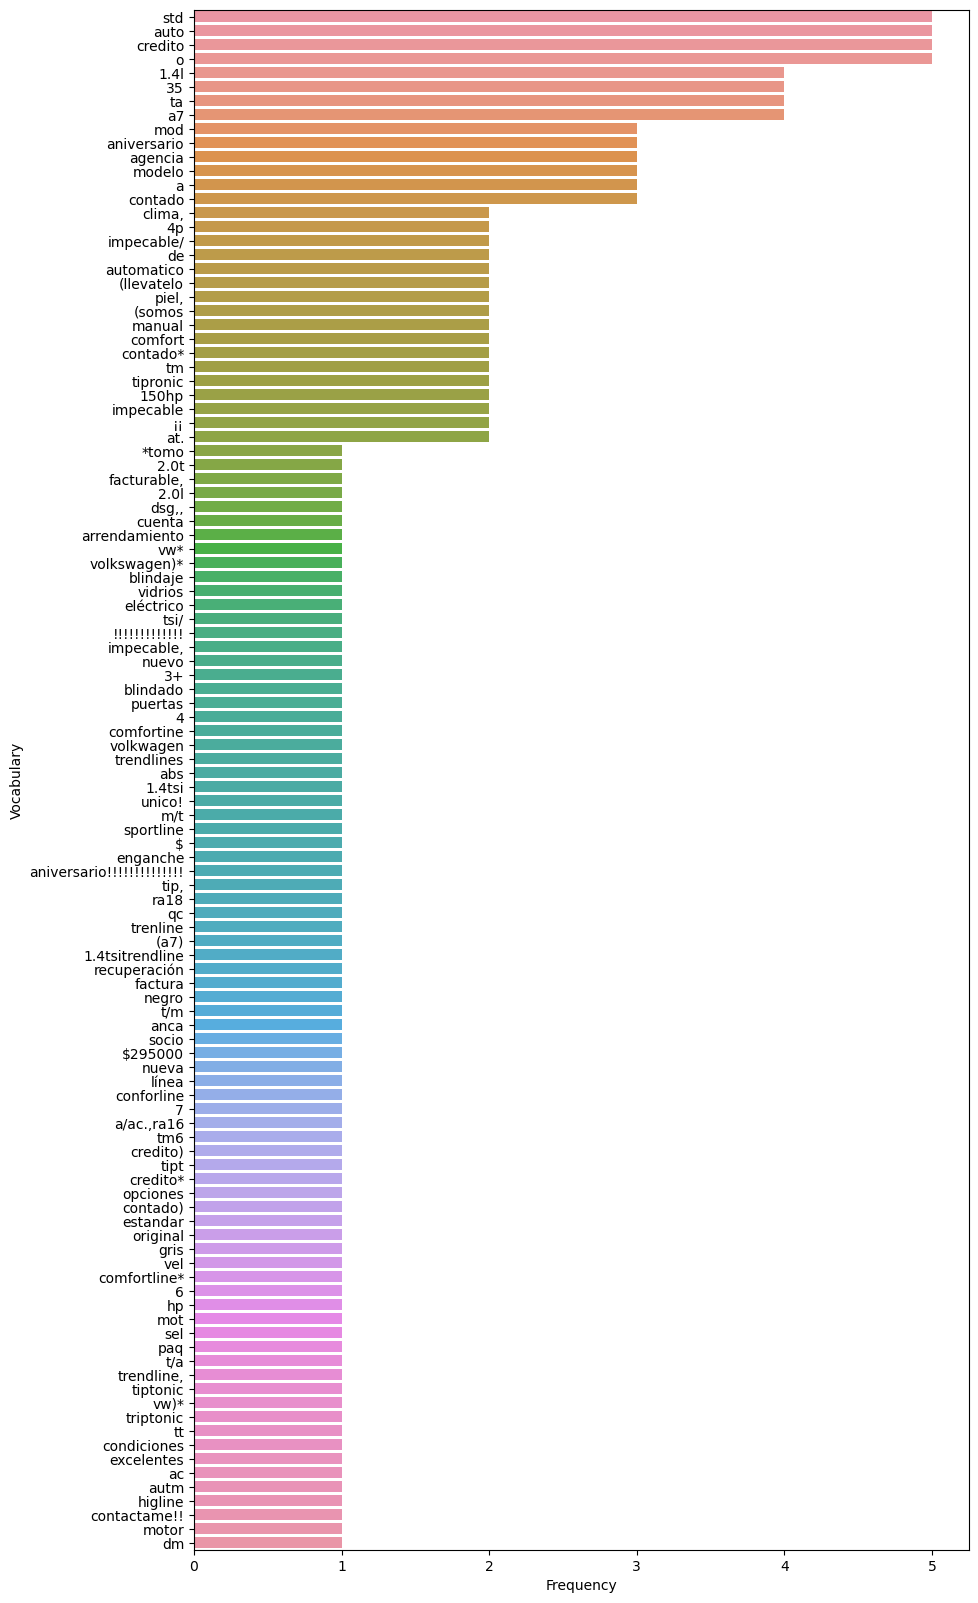

In [11]:
y_axes = less_common.index
x_axes = less_common.values

fig, ax = plt.subplots(1, 1, figsize=(10, 20))
sns.barplot(x=x_axes,y=y_axes,
            ax=ax)

ax.set_ylabel("Vocabulary")
ax.set_xlabel("Frequency")

plt.show()

In [12]:
# Cleaning
punctuation_patterns = re.compile(r"(\*|\?|\!|\¡|\(|\)|\$)+")
punctuation_patterns_special = re.compile(r"(\s+,+\s+|\s+\.+\s+)+")

# Personalized stopwords
stop_words = [
    "o","y","aniversario","agencia", "modelo",
    "a", "tomo", "facturable", "cuenta", "arrendamiento",
    "vidrios","blindaje", "impecable", "nuevo", "de", "blindado", "puertas", "unico",
    "enganche", "aniversario", "recuperación", "factura", "nueva", "credito", "línea",
    "opciones", "contado", "original", "condiciones", "excelentes", "contactame", "dm",
    "verde", "negro", "gris", "azul", "rojo", "blanco", "llevatelo", "socio", "piel", "clima"
             ]

common_stop_words = stopwords.words("spanish")
all_stop_words = stop_words + common_stop_words

stop_words_patterns = r"(\b" + r"\b|\b".join(all_stop_words) + r"\b)+"
stop_words_patterns = re.compile(stop_words_patterns)
spaces_patterns = re.compile(r"\s+")

def cleaning_text(text:str) -> str:
    new_text = punctuation_patterns.sub("", text)
    new_text = punctuation_patterns_special.sub(" ", new_text)
    new_text = stop_words_patterns.sub("", new_text)
    
    # Non printable characters
    new_text = new_text.replace("\n", " ").replace("\r", " ")
    
    new_text = spaces_patterns.sub(" ", new_text)
    
    return new_text

vw_df["Título"] = vw_df["Título"].apply(cleaning_text)

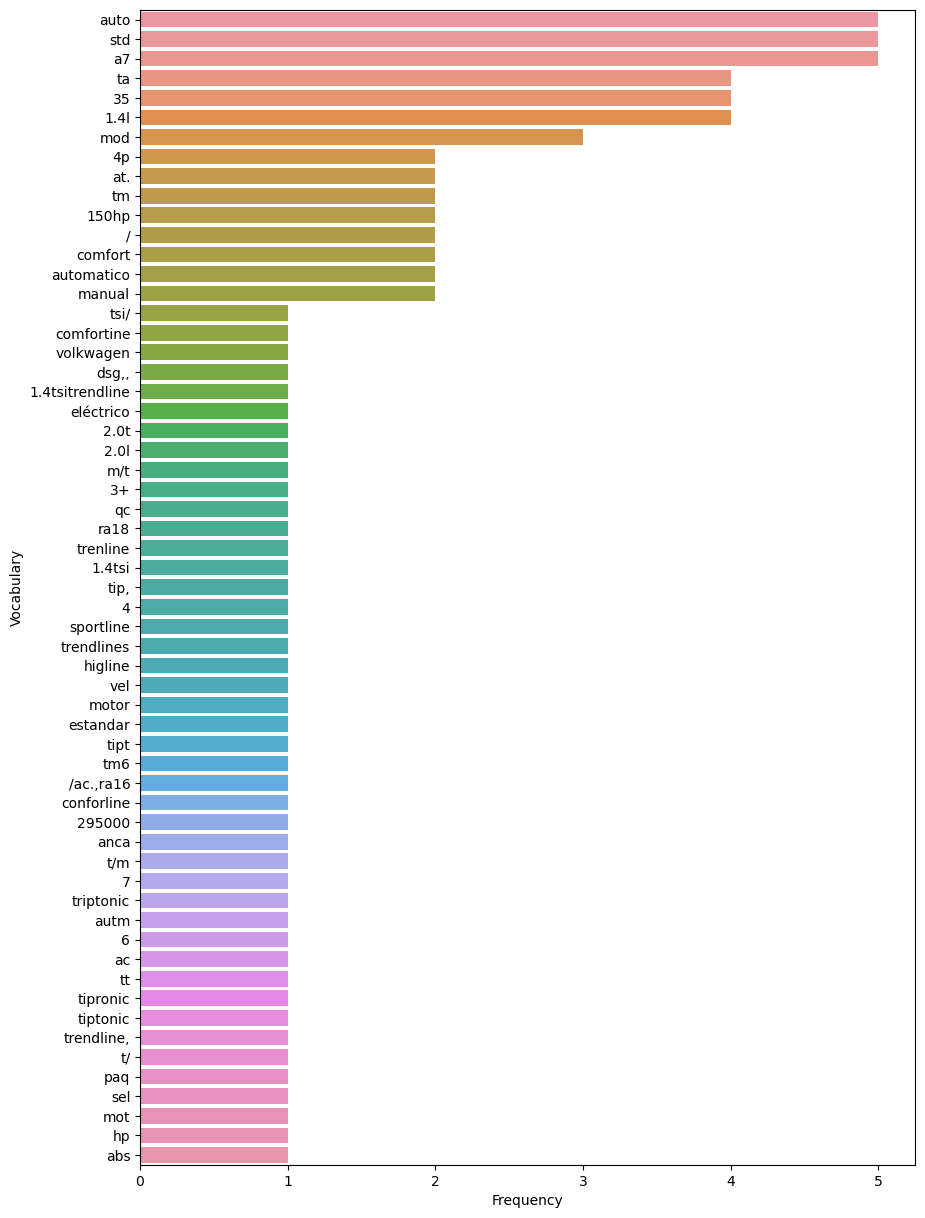

In [13]:
all_new_vocabulary = " ".join(vw_df["Título"].unique())
all_new_vocabulary = spaces_patterns.sub(" ", all_new_vocabulary)
all_new_vocabulary_counts = pd.Series(all_new_vocabulary.split(" ")).value_counts()

# Less common words (threshold 5)
less_common_new = all_new_vocabulary_counts[all_new_vocabulary_counts <= threshold]

x_axes = less_common_new.values
y_axes = less_common_new.index

fig, ax = plt.subplots(1, 1, figsize=(10, 15))
sns.barplot(x=x_axes,y=y_axes,
            ax=ax)

ax.set_ylabel("Vocabulary")
ax.set_xlabel("Frequency")

plt.show()

In [14]:
vectorizer = CountVectorizer(binary=True)
vectorizer.fit(vw_df["Título"])

CountVectorizer(binary=True)

In [15]:
one_hot_matrix = vectorizer.transform(vw_df["Título"])
print(f"Matrix shape: {one_hot_matrix.shape}")

Matrix shape: (412, 67)


In [35]:
components = 4
pca = PCA(n_components = components)
matrix_reduced = pca.fit_transform(one_hot_matrix.toarray())

print(f"Explained variance by component: {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {np.cumsum(pca.explained_variance_ratio_)}")

Explained variance by component: [0.19263412 0.11960153 0.09875706 0.08208161]
Cumulative explained variance: [0.19263412 0.31223565 0.41099271 0.49307432]


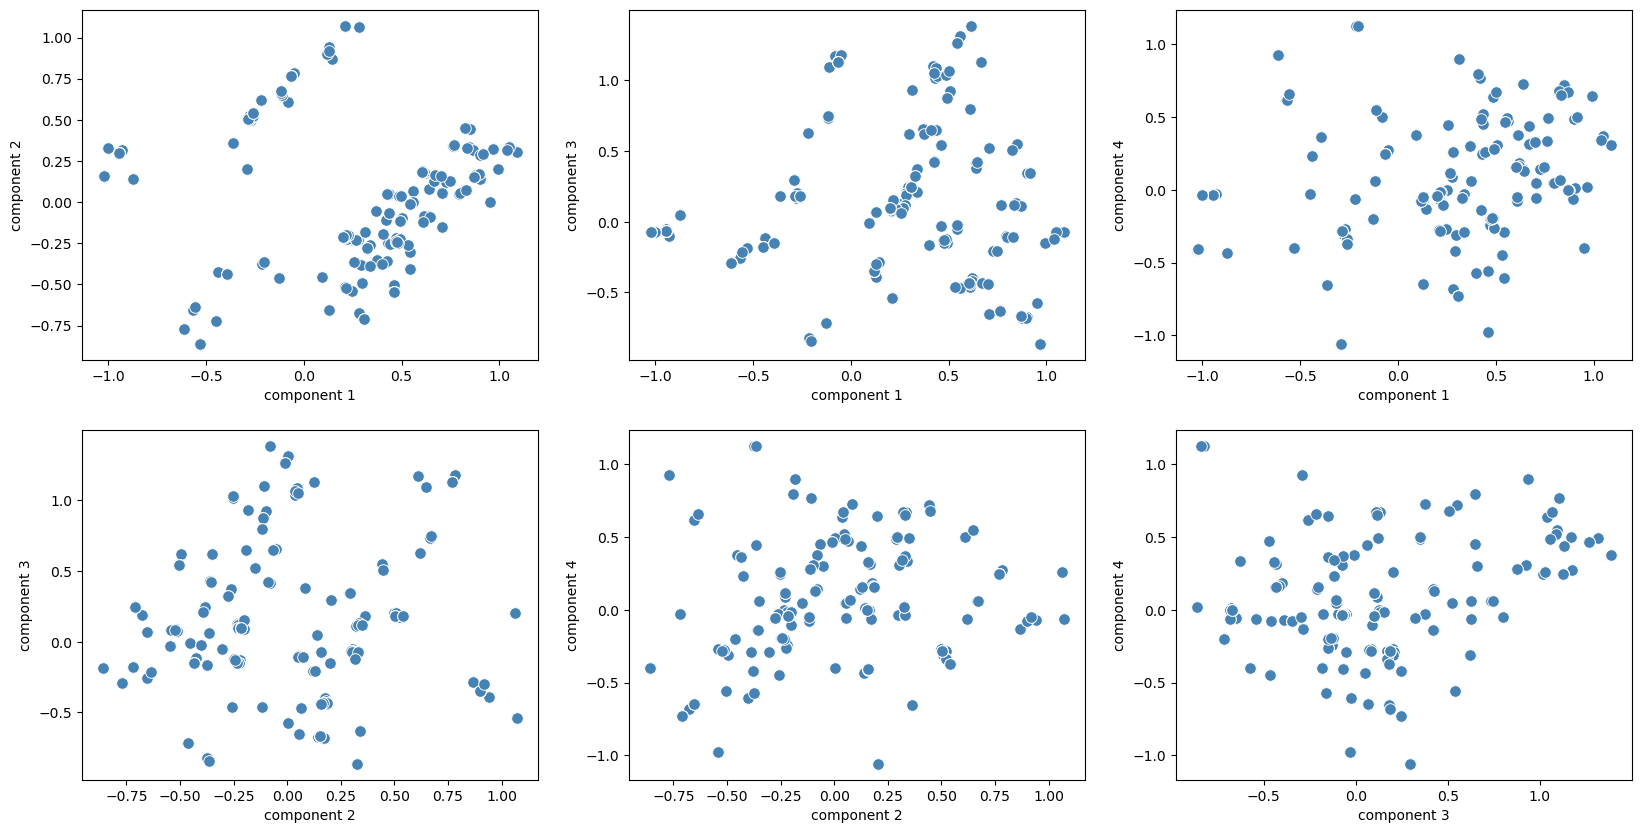

In [36]:
index_components = combinations(np.arange(0, components, 1), 2)

fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax = ax.flatten()

for plot_index, (i, j) in enumerate(index_components):
    
    sns.scatterplot(
        
        x = matrix_reduced[:,i],
        y = matrix_reduced[:,j],
        color = "steelblue",
        ax = ax[plot_index],
        #hue = vw_df["Versión"],
        legend=False,
        s=70
        
        )
    
    ax[plot_index].set_xlabel(f"component {i + 1}")
    ax[plot_index].set_ylabel(f"component {j + 1}")

plt.show()

In [37]:
kmeans = KMeans(n_clusters = 41)
kmeans.fit(one_hot_matrix)

KMeans(n_clusters=41)

In [38]:
cluster_means = kmeans.predict(one_hot_matrix)
cluster_means = list(map(lambda x: str(x), cluster_means))

In [39]:
t_nse = TSNE()
t_nse_components = t_nse.fit_transform(X = one_hot_matrix.toarray())

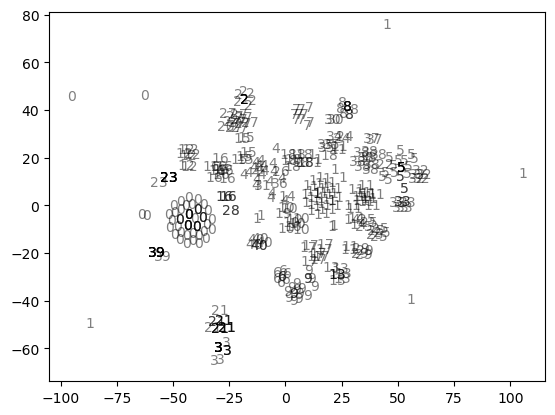

In [40]:
sns.scatterplot(

    x = t_nse_components[:,0], 
    y = t_nse_components[:,1],
    hue = cluster_means,
    legend = False,
    s = 0

    )

for i in range(len(cluster_means)):
    plt.annotate(
    
        cluster_means[i],
        (t_nse_components[i,0], t_nse_components[i,1]),
        textcoords="offset points",
        xytext=(0,0),
        ha='center',
        alpha = 0.5
    
    )

plt.show()

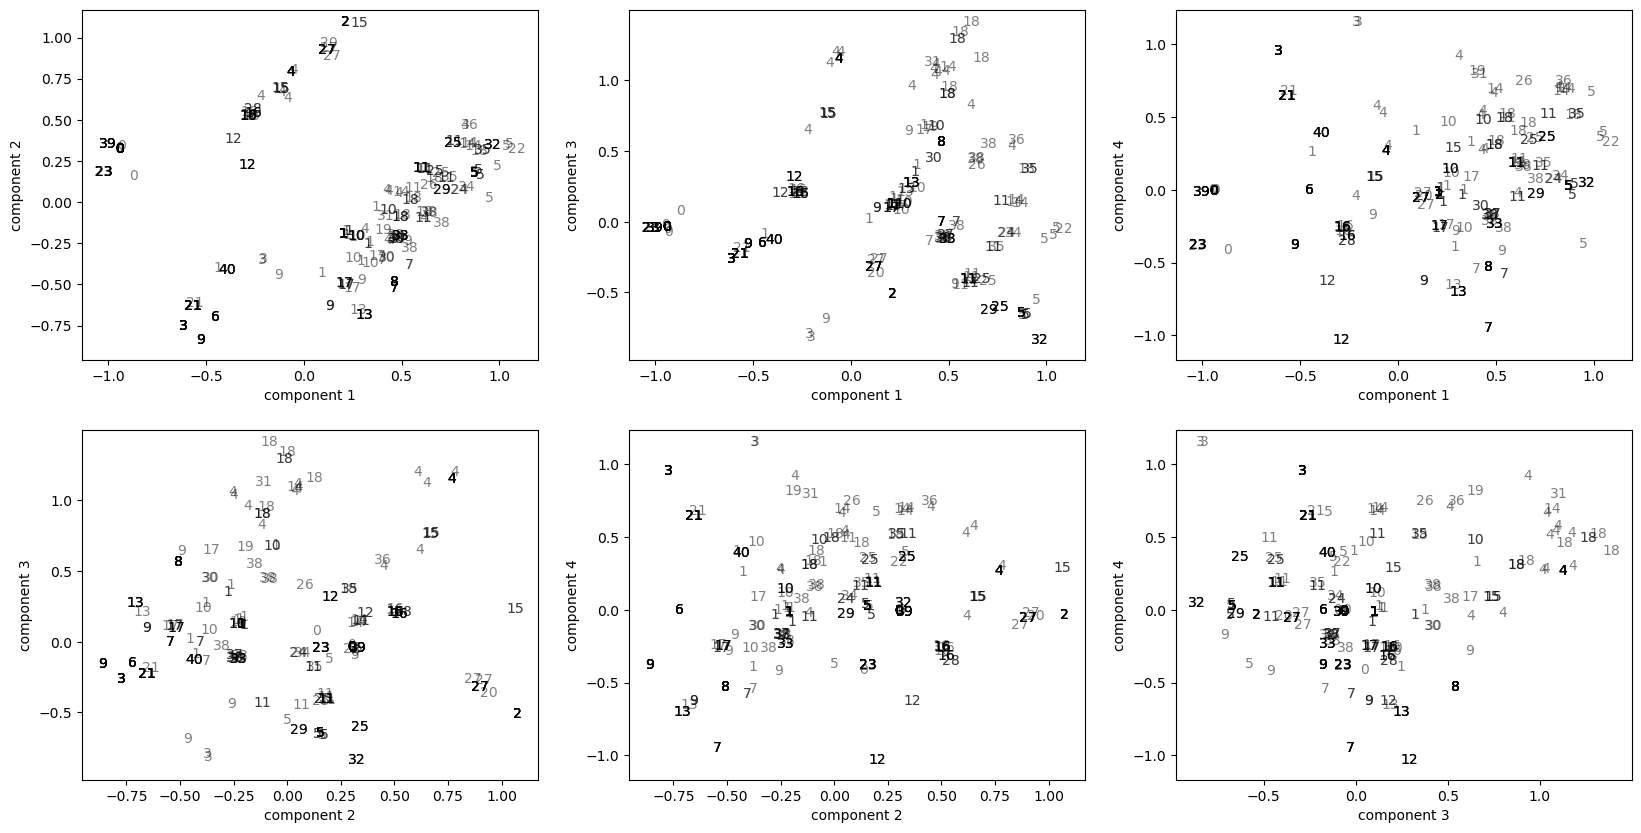

In [44]:
index_components = combinations(np.arange(0, components, 1), 2)

fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax = ax.flatten()

for plot_index, (i, j) in enumerate(index_components):
    
    sns.scatterplot(

        x=matrix_reduced[:, i],
        y=matrix_reduced[:, j],
        color="steelblue",
        ax=ax[plot_index],
        legend=False,
        s=0

    )
    
    for row in range(len(cluster_means)):  

        ax[plot_index].annotate(

            str(cluster_means[row]),
            (matrix_reduced[row, i], matrix_reduced[row, j]),
            textcoords="offset points",
            xytext=(0, 0),
            ha='center',
            alpha=0.5
        
        )
    
    ax[plot_index].set_xlabel(f"component {i + 1}")
    ax[plot_index].set_ylabel(f"component {j + 1}")

plt.show()


In [22]:
vw_df["cluster_kmeans"] = cluster_means
cluster_one = vw_df[vw_df["cluster_kmeans"] == "1"]

cluster_one[["Título", "Versión"]].value_counts()

Título                                                  Versión              
volkswagen jetta 2019 1.4 t fsi comfortline             1.4 t fsi comfortline    51
volkswagen jetta 2019 1.4 t fsi comfortline at          1.4 t fsi comfortline     1
volkswagen jetta 2019 1.4 t fsi comfortline automatico  1.4 t fsi comfortline     1
volkswagen jetta 2019 1.4 t fsi comfortline std         1.4 t fsi comfortline     1
volkswagen jetta 2019 1.4t std fsi comfortline 2019     1.4 t fsi comfortline     1
volkswagen jetta 2019 comfortline 1.4 fsi               1.4 t fsi comfortline     1
Name: count, dtype: int64

In [23]:
cluster_two = vw_df[vw_df["cluster_kmeans"] == "2"]

cluster_two[["Título", "Versión"]].value_counts()

Título                                        Versión                        
volkswagen jetta 2019                         1.4 t fsi comfortline              11
                                              1.4 t fsi tiptronic comfortline     7
                                              1.4 t fsi rline tip                 6
                                              1.4 t fsi highline tiptronic        3
                                              2.5 trendline tiptronic at          2
                                              1.4 t fsi tipronic comfortline      2
                                              4p trendline l4/1.4/t man           2
volkswagen jetta 2019 2.5 sportline mt        2.5 sportline mt                    2
volkswagen jetta 2019 1.4 turbo confortline   1.4 t fsi comfortline               1
volkswagen jetta rline autm 2019              1.4 t fsi rline                     1
volkswagen jetta higline 2019                 1.4 t fsi highline tiptronic        

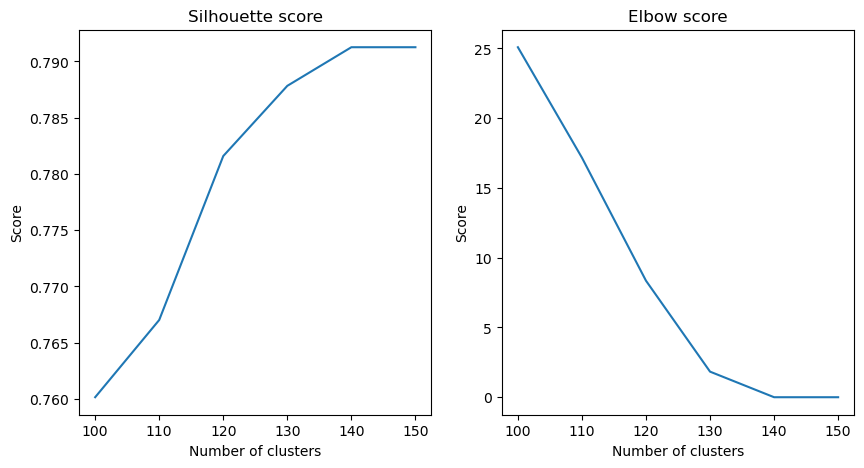

In [54]:
experiment_components = np.arange(100, 160, 10)
silhouette_results = []
elbow_score = []

for component_exp in experiment_components:

    kmeans = KMeans(n_clusters=component_exp, random_state=42)
    clusters_experiment = kmeans.fit_predict(one_hot_matrix)

    elbow_score.append(kmeans.inertia_)

    score_s = silhouette_score(one_hot_matrix, clusters_experiment)
    silhouette_results.append(score_s)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(x = experiment_components, y = silhouette_results, ax=ax[0])
ax[0].set_title("Silhouette score")
ax[0].set_ylabel("Score")
ax[0].set_xlabel("Number of clusters")

sns.lineplot(x = experiment_components, y = elbow_score, ax=ax[1])
ax[1].set_title("Elbow score")
ax[1].set_ylabel("Score")
ax[1].set_xlabel("Number of clusters")

plt.show()

In [25]:
LDA = LatentDirichletAllocation(n_components = 41)
cluster_lda = LDA.fit_transform(one_hot_matrix)
cluster_lda = list(map(lambda x: str(x), np.argmax(cluster_lda, axis=1)))

vw_df["cluster_lda"] = cluster_lda

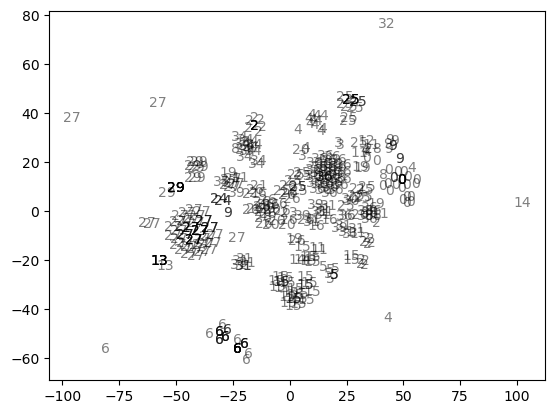

In [26]:
sns.scatterplot(

    x = t_nse_components[:,0], 
    y = t_nse_components[:,1],
    hue = cluster_lda,
    legend = False,
    s = 0

    )

for i in range(len(cluster_means)):
    plt.annotate(
    
        cluster_lda[i],
        (t_nse_components[i,0], t_nse_components[i,1]),
        textcoords="offset points",
        xytext=(0,0),
        ha='center',
        alpha = 0.5
    
    )

plt.show()

In [27]:
cluster_lda_seventeen = vw_df[vw_df["cluster_lda"] == "32"]
cluster_lda_seventeen[["Título", "Versión"]].value_counts()

Título                         Versión                     
volkswagen jetta higline 2019  1.4 t fsi highline tiptronic    1
Name: count, dtype: int64